# Air quality prediction service

Baseado na API do site: https://aqicn.org/, é possível obter o Indíce de Qualidade do Ar (AQI) de diversas cidades no mundo, de modo que com o aumento do índice, maior o risco pra população. Entre as cidades listadas, consta a cidade de Santos - SP. 
Santos é uma cidade que atrai muitos turistas, principalmente no verão, por ser uma cidade litorânea, ademais apresenta um índice de qualidade do ar, eventualmente, no nível Moderado, no qual indica um leve risco para pessoas mais sensíveis a poluição do ar.

Desse modo, este projeto visa a implementação de um projeto completo de Machine Learning, visando a previsão da qualidade do ar da cidade de Santos para os próximos dias. As etapas do projeto serão divididas como a seguir:

- Coleta dos dados históricos 
- Preparação dos Dados para o modelo
- Treinamento do Modelo
- Coleta do AQI em tempo real via API 
- Deploy do Modelo via Streamlit

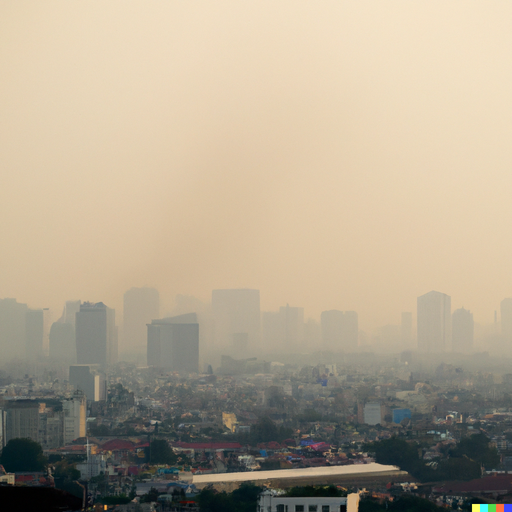

In [1]:
from IPython import display
display.Image("air-polution.png")


## Coleta dos Dados históricos

A coleta dos dados históricos pode ser obtida pelo Data Platform do site: https://aqicn.org/data-platform/register/

Nesta etapa também será realizado a importação das bibliotecas utilizadas no projeto, além da coleta dos Dados da cidade de Santos.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima import auto_arima
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
import pmdarima as pm
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

In [77]:
df = pd.read_csv('tietê.csv')
df.sort_values(by = 'date',inplace=True,ascending=True)
cols = [' pm25', ' pm10', ' o3',' no2',' so2', ' co']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
pd.to_datetime(df['date'])
#df.set_index('date',inplace=True)
#df = df.apply(pd.to_numeric, errors='coerce') 
df

date   pm25   pm10   o3   no2   so2    co
3293   2014/1/1    NaN   19.0  NaN   NaN   NaN   5.0
3157  2014/1/10   74.0   39.0  NaN  42.0   2.0  10.0
3158  2014/1/11   90.0   39.0  NaN  32.0   1.0  11.0
3159  2014/1/12   89.0   19.0  NaN  21.0   NaN  10.0
3160  2014/1/13   61.0   33.0  NaN  33.0   1.0  11.0
...         ...    ...    ...  ...   ...   ...   ...
1      2023/2/5   32.0   13.0  NaN  13.0   NaN   NaN
2      2023/2/6   33.0   25.0  NaN  25.0   1.0   8.0
3      2023/2/7   62.0   24.0  NaN  25.0   NaN   7.0
4      2023/2/8   62.0   21.0  NaN  15.0   NaN   4.0
5      2023/2/9   52.0   24.0  NaN  24.0   NaN   5.0

[3297 rows x 7 columns]

In [79]:
start_date = '2014/01/01'
end_date = '2023/02/09'
idx = pd.date_range(start=start_date, end=end_date, freq='D')
df_data = pd.DataFrame({'datetime': idx})
pd.to_datetime(df_data['datetime'])
df_data

datetime
0    2014-01-01
1    2014-01-02
2    2014-01-03
3    2014-01-04
4    2014-01-05
...         ...
3322 2023-02-05
3323 2023-02-06
3324 2023-02-07
3325 2023-02-08
3326 2023-02-09

[3327 rows x 1 columns]

In [81]:
type(df_data['datetime'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [82]:
type(df['date'][0])

str

In [57]:
df = pd.read_csv('tietê.csv')
#pd.to_datetime(df["newdate"])
# df.sort_values(by = 'newdate',inplace=True,ascending=True)
# df.set_index('newdate',inplace=True)
df.sort_values(by = 'date',inplace=True,ascending=True)
df.set_index('date',inplace=True)
df = df.apply(pd.to_numeric, errors='coerce') 
pd.to_datetime(df.index)
df

TypeError: to_datetime() got an unexpected keyword argument 'inplace'

In [12]:
pd.to_datetime(df["newdate"])
df.sort_values(by = 'newdate',inplace=True,ascending=True)
df.set_index('newdate',inplace=True)

KeyError: 'newdate'

- pm25: Partículas finas com diâmetro de 2,5 mícrons ou menor, inalável ​​para os pulmões e podem induzir efeitos adversos à saúde. 
- pm10: Partículas com diâmetro de 10 mícrons, inalável ​​para os pulmões e podem induzir efeitos adversos à saúde.
- o3: Ozone scale. 
- no2: Nitrogen Dioxide scale.
- so2: Sulphur dioxide scale. 

## Preparação dos Dados para o modelo

Utilizando o método built-in info(), pode-se observar o tipo de cada coluna do Dataframe e valores não nulos. Verificando o dataset percebe-se a ocorrência de valores nulos os quais não foram apresentados com o metodo info(), isso ocorre devido aos tipos observados nas colunas serem object e, para verificação dos valores nulos, as colunas devem ser do tipo numéricas (como int ou float).

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3289 entries, 2014/1/1 to 2023/2/9
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0    pm25   3289 non-null   object
 1    pm10   3289 non-null   object
 2    o3     3289 non-null   object
 3    no2    3289 non-null   object
 4    so2    3289 non-null   object
 5    co     3289 non-null   object
dtypes: object(6)
memory usage: 179.9+ KB


In [ ]:
#Usar df.astype('float') diretamente ocasionou em erro devido aos null-values
df = df.apply(pd.to_numeric, errors='coerce') 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3289 entries, 2014/1/1 to 2023/2/9
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0    pm25   3232 non-null   float64
 1    pm10   3229 non-null   float64
 2    o3     3132 non-null   float64
 3    no2    3163 non-null   float64
 4    so2    2540 non-null   float64
 5    co     7 non-null      float64
dtypes: float64(6)
memory usage: 179.9+ KB


- A coluna "co" apresenta apenas 7 valores, desse modo, não irá interferir na predição, podendo dropar a coluna.
- A coluna "so2 apresenta valores nulos significativos.
- As outras apresentam uma faixa de 3% dos valores nulos, esperamos que isso não afete significativamente o modelo.
Visando preencher os valores nulos do Dataset, foi utilizado o método Interpolate() 


In [ ]:
df.drop(df.columns[5],axis = 1,inplace=True)
df.drop(index='2014/1/1',inplace=True)
df.interpolate(inplace=True)
df.head(20)

pm25   pm10         o3        no2    so2
date                                                
2014/1/10   50.0   34.0  15.000000  11.000000   5.00
2014/1/11   64.0   38.0  21.000000  12.000000   7.00
2014/1/12   67.0   22.0  15.000000   8.000000   2.00
2014/1/13   50.0   27.0  13.000000  13.000000   3.00
2014/1/14   50.0   41.0  30.000000  14.000000  10.00
2014/1/15   70.0   29.0  27.000000  15.000000   6.00
2014/1/16   61.0   28.0  13.000000  14.000000   7.00
2014/1/17   59.0   30.0  17.000000  13.000000   8.00
2014/1/18   59.0   26.0  11.000000   9.000000   5.00
2014/1/19   57.0   18.0  11.000000   7.000000   4.00
2014/1/2    75.0   21.0  16.000000  11.000000   2.00
2014/1/20   43.0   28.0  13.000000   8.000000  11.00
2014/1/21   56.0   34.0  15.000000  13.000000   6.00
2014/1/22   69.0   38.0  28.000000  13.000000   8.00
2014/1/23   68.0   45.0  27.000000  17.000000  11.00
2014/1/24   78.0   42.0  37.000000  17.000000  11.00
2014/1/25   73.0   34.0  40.000000  14.000000   6.00
2014/1/26   63.0   29.0  31.666667  10.666667   6.75
2014/1/27   62.0   22.0  23.333333   7.333333   7.50
2014/1/28   47.0   34.0  15.000000   4.000000   8.25

In [ ]:
df = pd.read_csv('SP202102.csv')
# pd.to_datetime(df["date"])
# df.sort_values(by = 'date',inplace=True,ascending=True)
# df.set_index('date',inplace=True)
df

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xed in position 74: invalid continuation byte

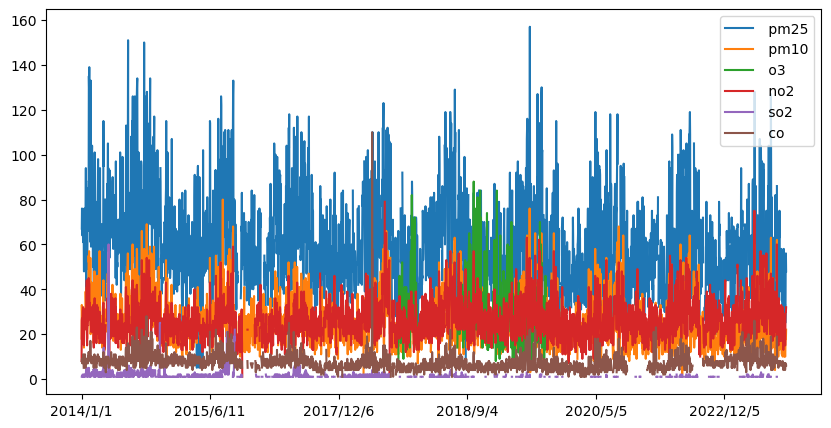

In [ ]:
plt.figure(figsize=(10,5))
for column in df.columns:
    plt.plot(df[column], label=column)
plt.xticks(np.arange(0, len(df.index), 600))
plt.legend()
plt.show()

Cada tipo de partícula de ar (pm25, o3, no2,...) possui um indíce de qualidade específico. O site apresenta o índice pm25 ou pm10, definido pelo qual estiver maior no momento da coleta para cada cidade. É possível verificar na foto acima que o pm25 na cidade de Santos é frequentemente maior que o pm10, ou seja, esse valor é sempre o considerado, de uma maneira geral, para indicar a qualidade do ar. Portanto, o modelo de machine learning será aplicado ao pm25. 

## Treinamento do Modelo

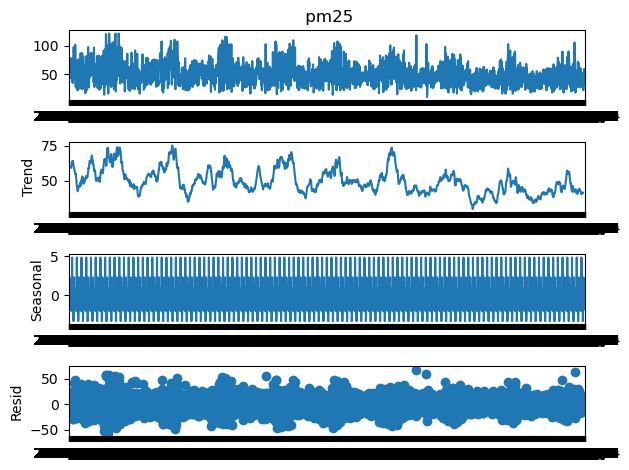

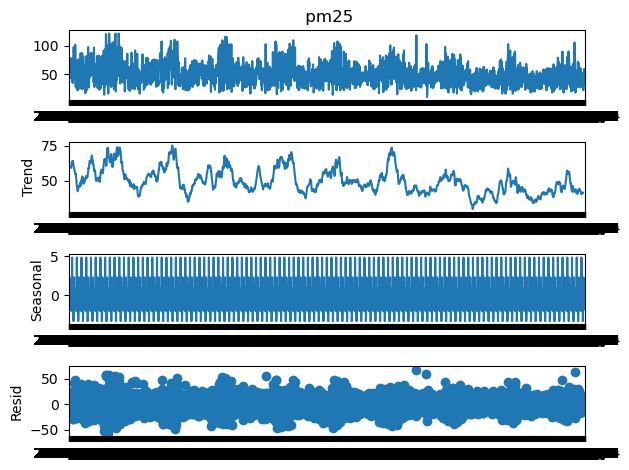

In [ ]:
decompose = seasonal_decompose(df[" pm25"],period=30)
decompose.plot()

In [ ]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

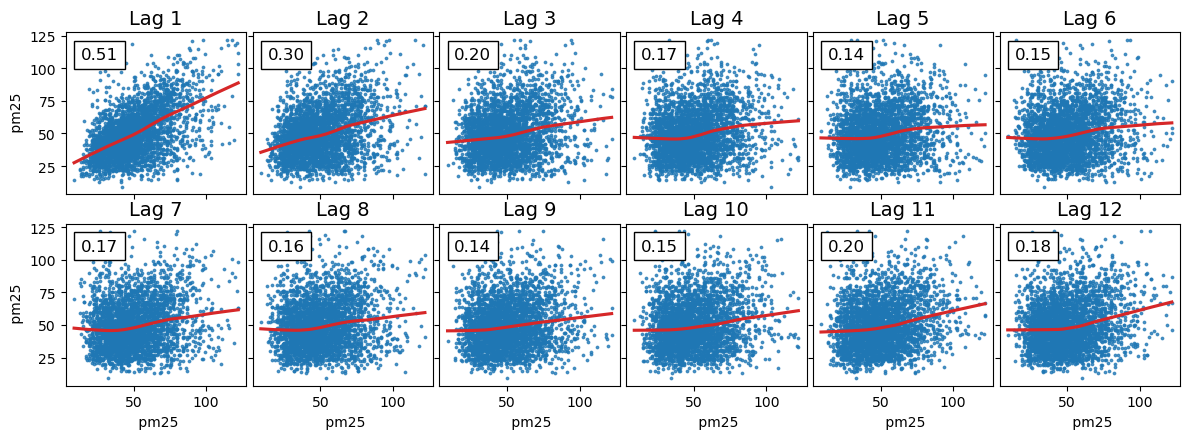

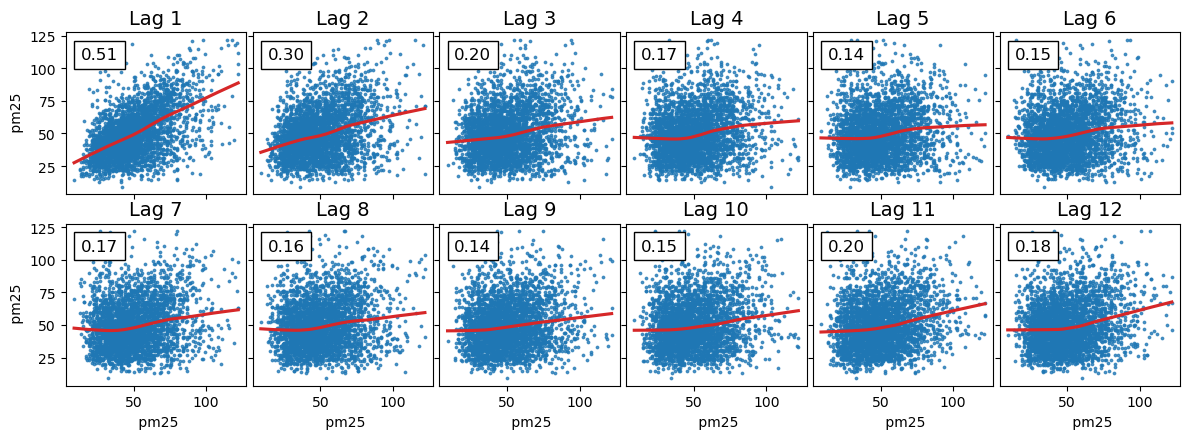

In [ ]:
plot_lags(df[' pm25'], lags=12, nrows=2)

<AxesSubplot:>

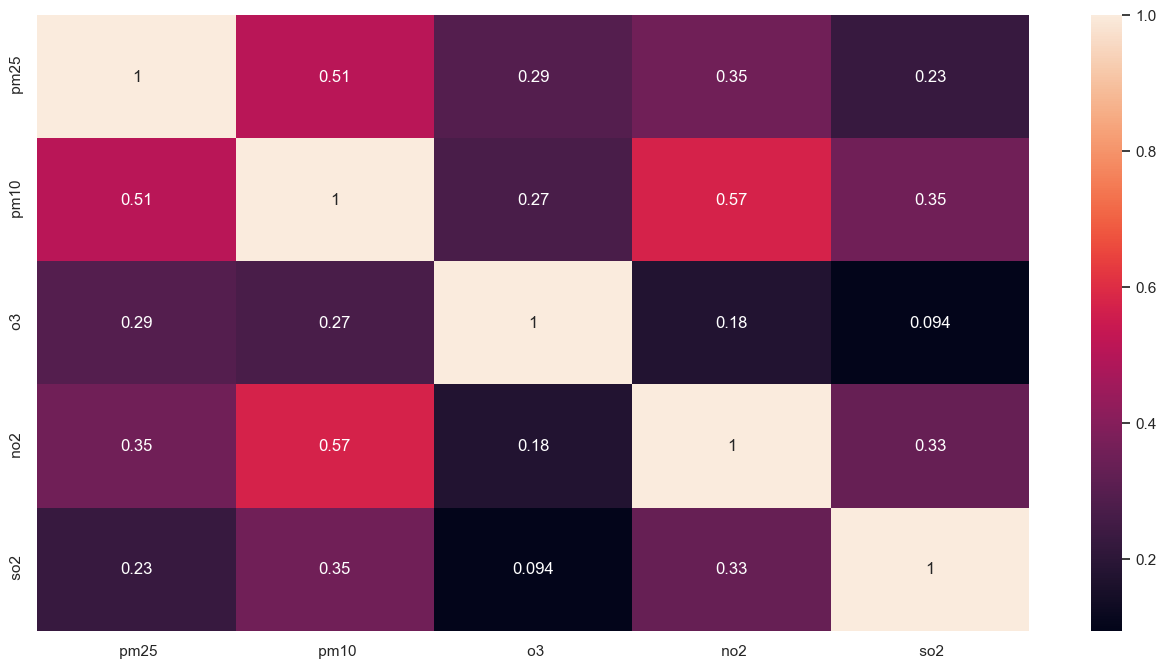

In [ ]:
sns.set(rc = {'figure.figsize':(16,8)})
sns.heatmap(df.corr(), annot = True)

In [ ]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

X = make_lags(df[" pm25"], lags=1)
X = X.fillna(0.0)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

In [ ]:
y = df[' pm25'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

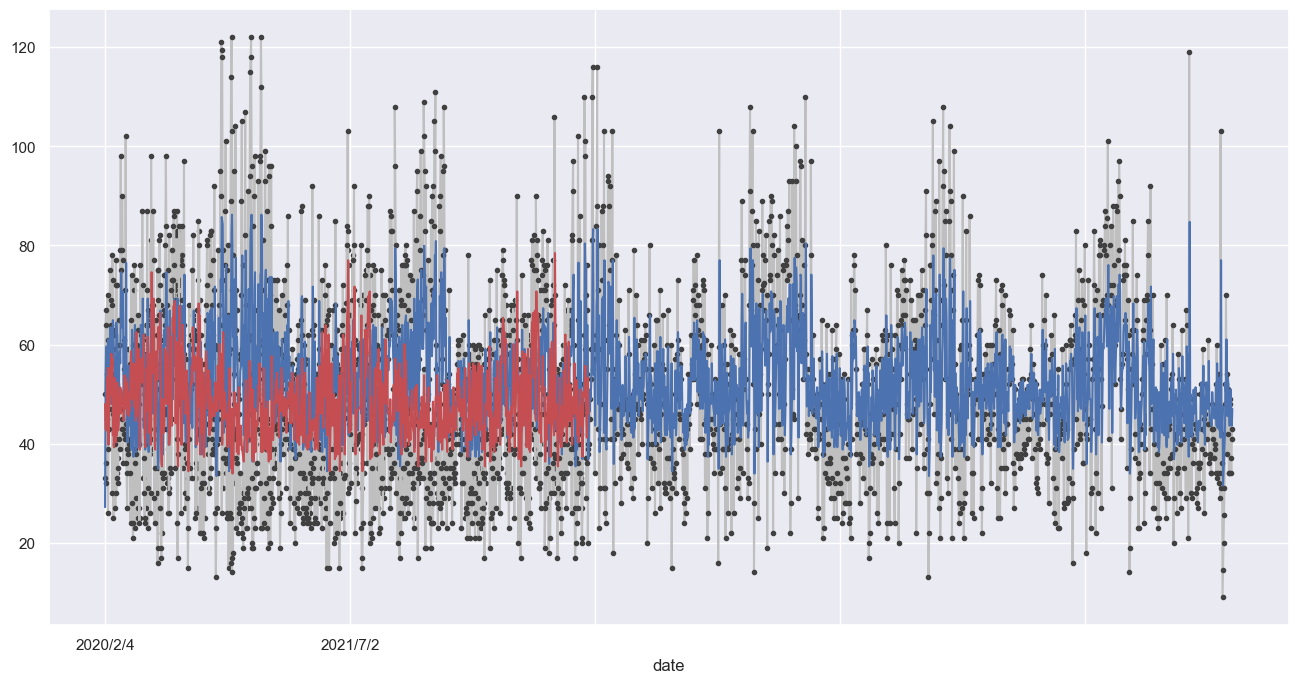

In [ ]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

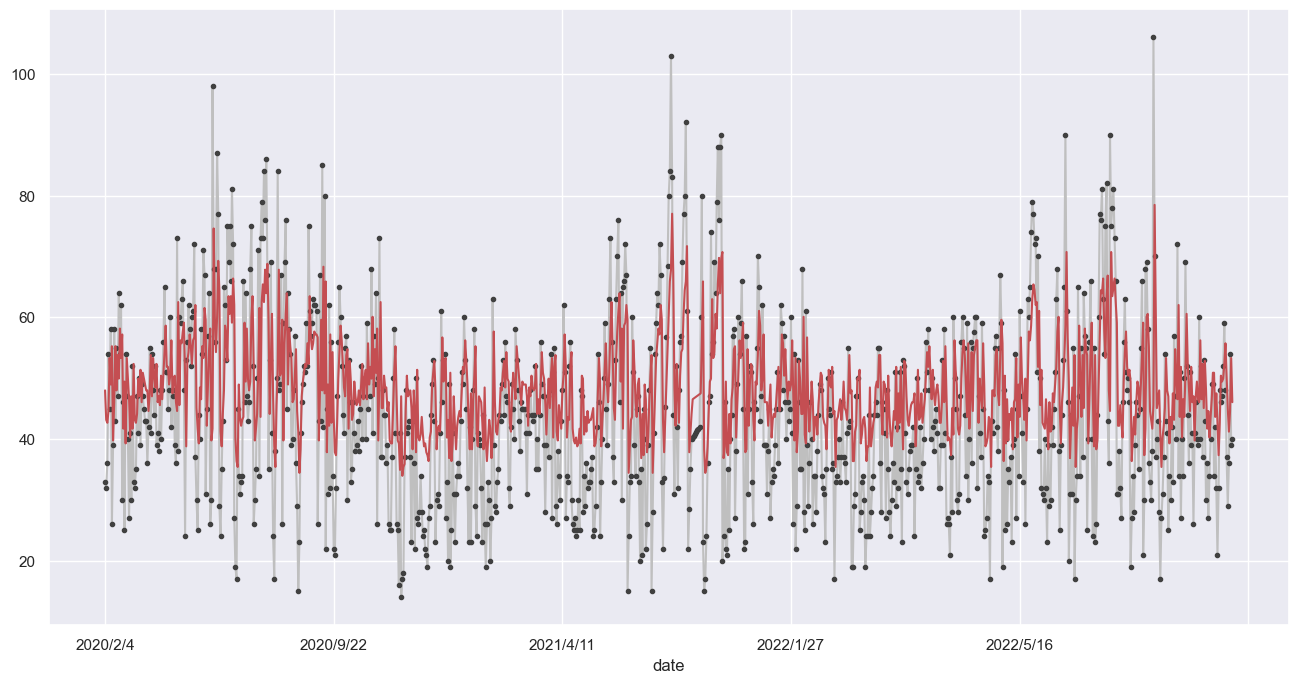

In [ ]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

In [ ]:
from sklearn.metrics import mean_squared_log_error

MSLE = mean_squared_log_error(y_test, y_fore) ** 0.5
print(f'Training RMSLE: {MSLE:.5f}')

RMSE = mean_squared_error(y_test, y_fore) ** 0.5
print(f'Training RMSE: {RMSE:.5f}')


Training RMSLE: 0.33925
Training RMSE: 14.09645


Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# Fit and predict
model = DecisionTreeRegressor()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

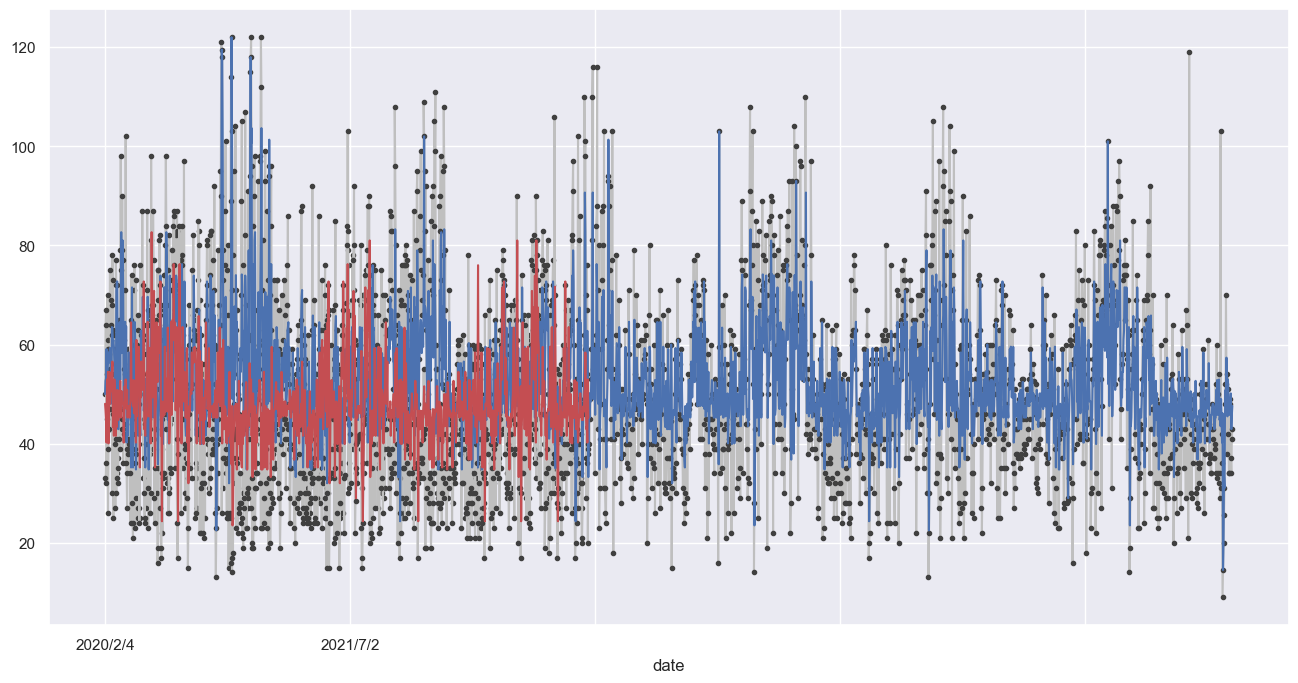

In [ ]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

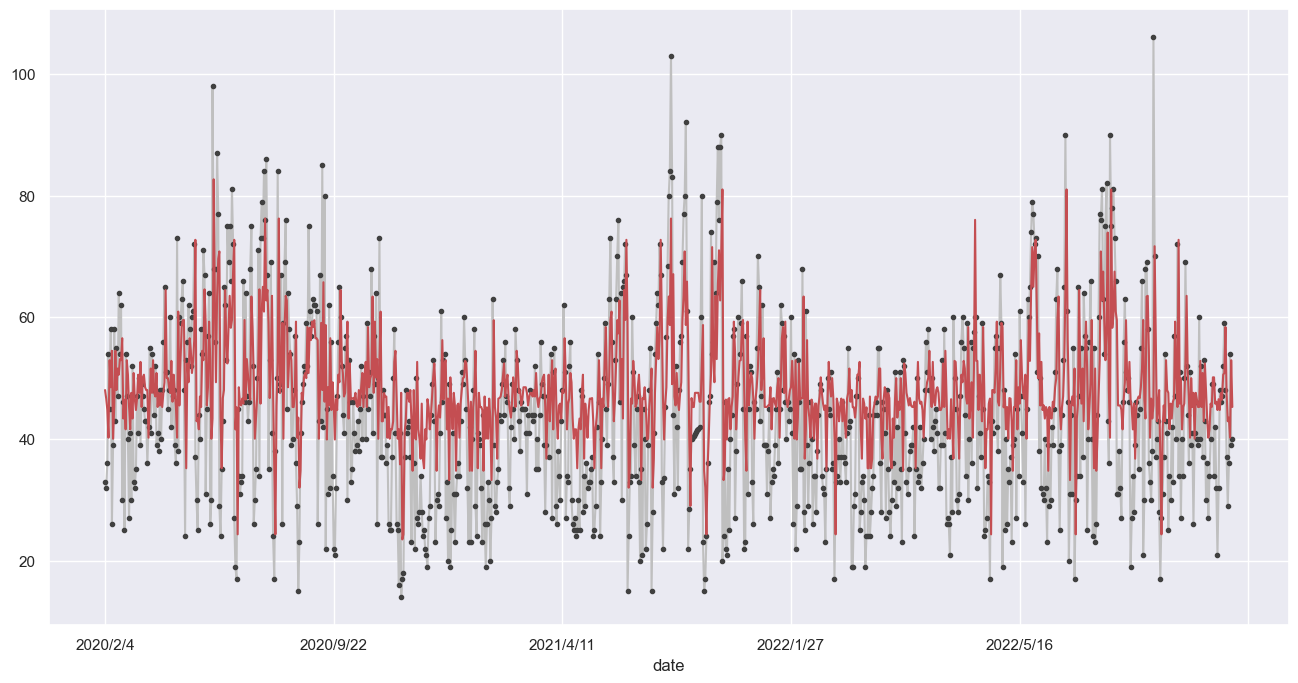

In [ ]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

In [ ]:
MSLE = mean_squared_log_error(y_test, y_fore) ** 0.5
print(f' RMSLE: {MSLE:.5f}')

RMSE = mean_squared_error(y_test, y_fore) ** 0.5
print(f' RMSE: {RMSE:.5f}')

Training RMSLE: 0.34564
Training RMSE: 14.47191


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Fit and predict
model = RandomForestRegressor()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

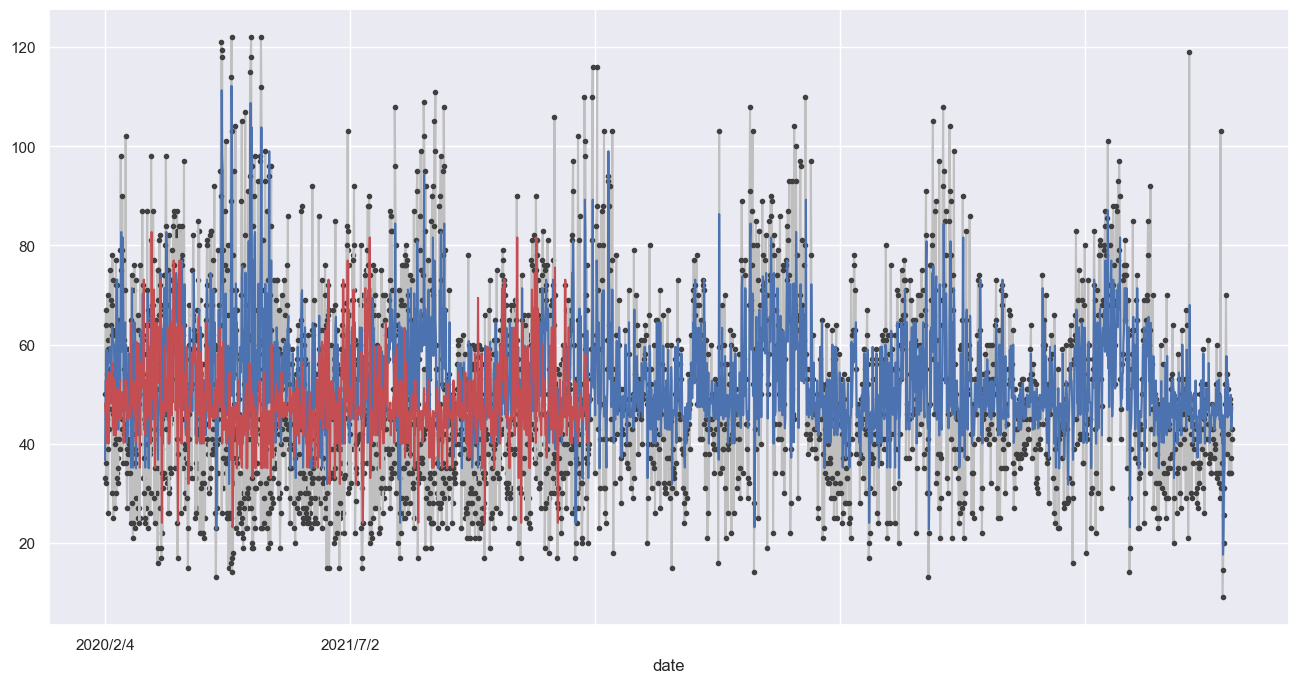

In [ ]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

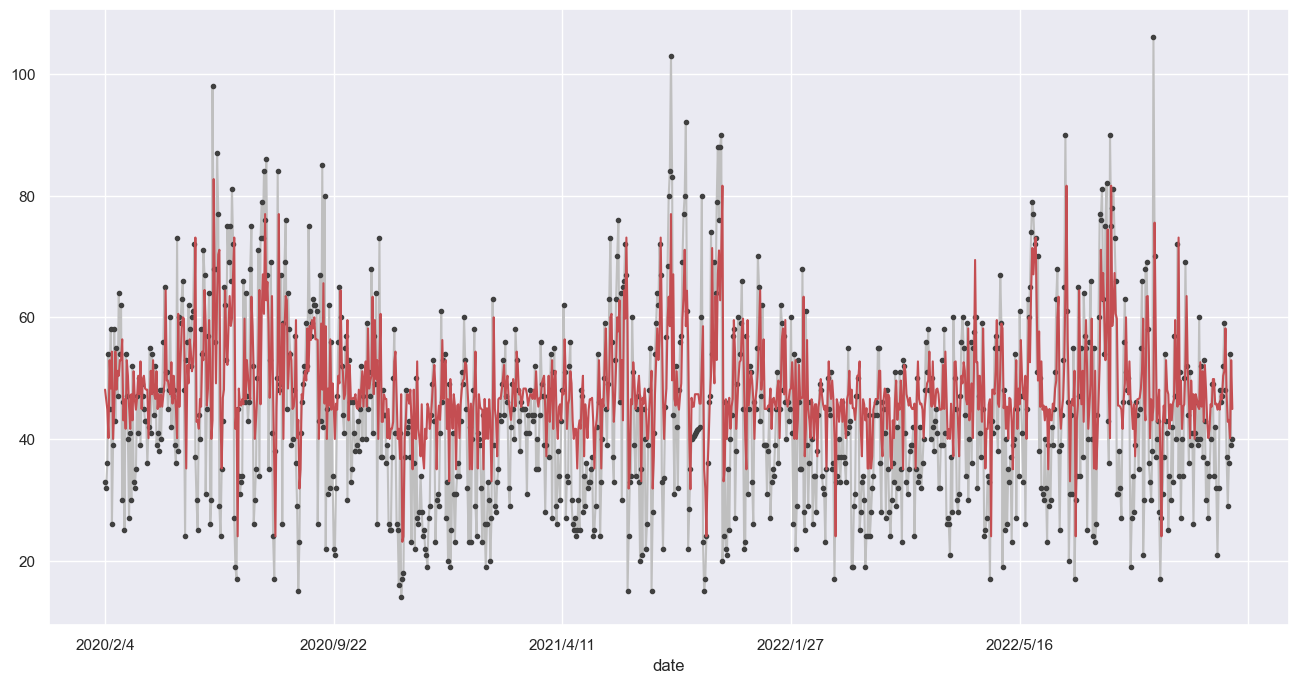

In [ ]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

In [ ]:
MSLE = mean_squared_log_error(y_test, y_fore) ** 0.5
print(f'RMSLE: {MSLE:.5f}')

RMSE = mean_squared_error(y_test, y_fore) ** 0.5
print(f'RMSE: {RMSE:.5f}')

Training RMSLE: 0.34478
Training RMSE: 14.43559


In [ ]:
from xgboost import XGBRegressor
# Fit and predict
model = XGBRegressor()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

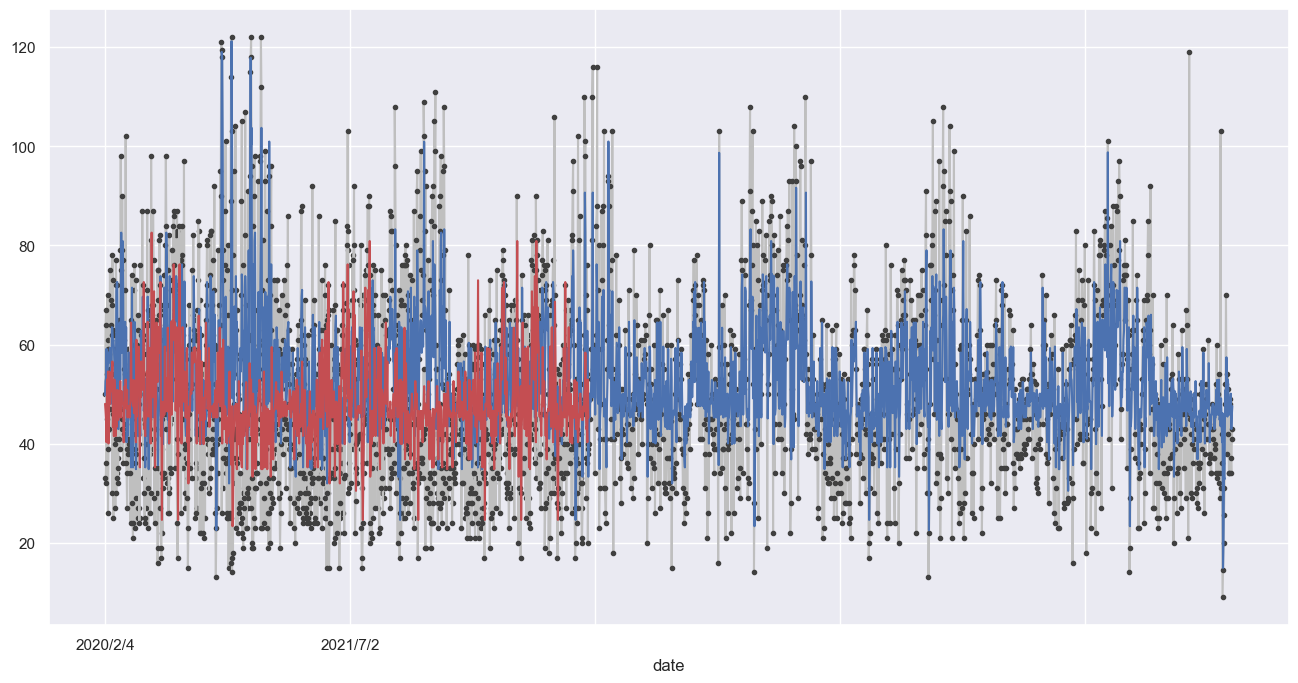

In [ ]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

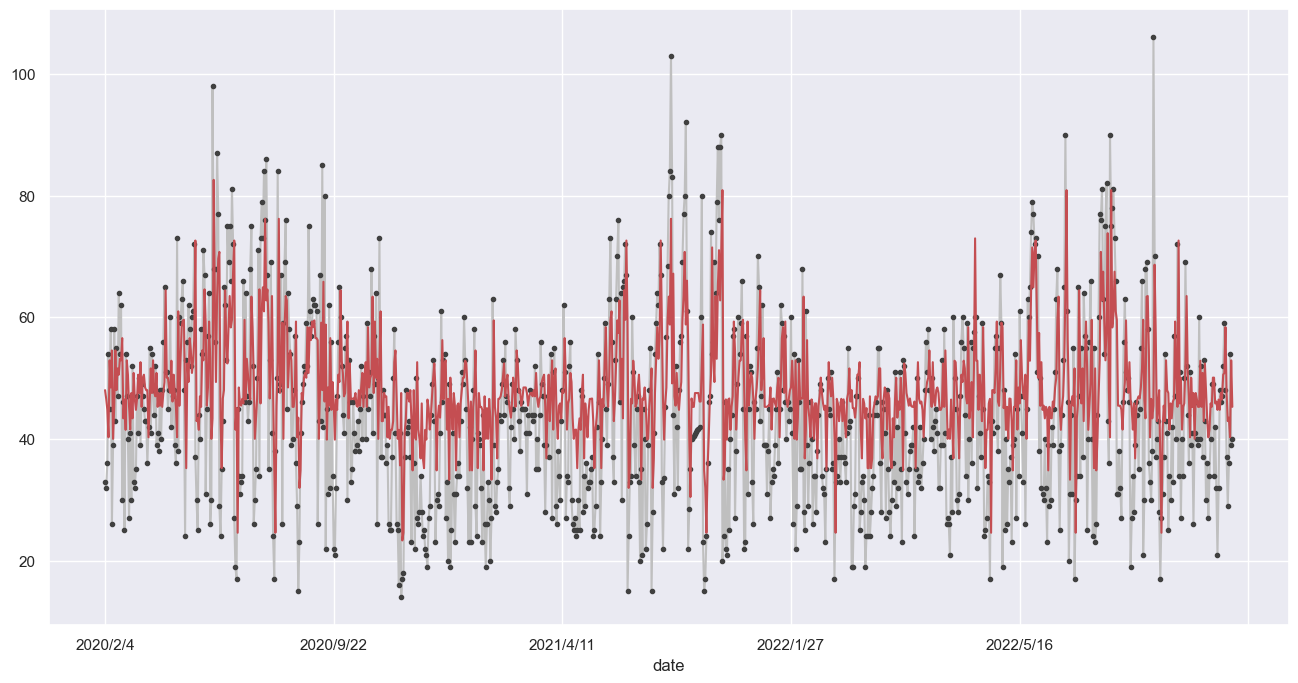

In [ ]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

In [ ]:
MSLE = mean_squared_log_error(y_test, y_fore) ** 0.5
print(f'RMSLE: {MSLE:.5f}')

RMSE = mean_squared_error(y_test, y_fore) ** 0.5
print(f'RMSE: {RMSE:.5f}')

RMSLE: 0.34544
RMSE: 14.46177


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=30)

Epoch 1/30
2301/2301 [==============================] - 24s 7ms/step - loss: 386.7393
Epoch 2/30
2301/2301 [==============================] - 41s 18ms/step - loss: 309.0263
Epoch 3/30
2301/2301 [==============================] - 30s 13ms/step - loss: 305.9844
Epoch 4/30
2301/2301 [==============================] - 29s 13ms/step - loss: 302.9233
Epoch 5/30
2301/2301 [==============================] - 25s 11ms/step - loss: 308.4879
Epoch 6/30
2301/2301 [==============================] - 23s 10ms/step - loss: 303.8772
Epoch 7/30
2301/2301 [==============================] - 20s 9ms/step - loss: 301.1870
Epoch 8/30
2301/2301 [==============================] - 32s 14ms/step - loss: 299.1633
Epoch 9/30
2301/2301 [==============================] - 20s 9ms/step - loss: 297.9121
Epoch 10/30
2301/2301 [==============================] - 18s 8ms/step - loss: 295.0532
Epoch 11/30
2301/2301 [==============================] - 28s 12ms/step - loss: 298.1014
Epoch 12/30
2301/2301 [======================

31/31 [==============================] - 2s 4ms/step


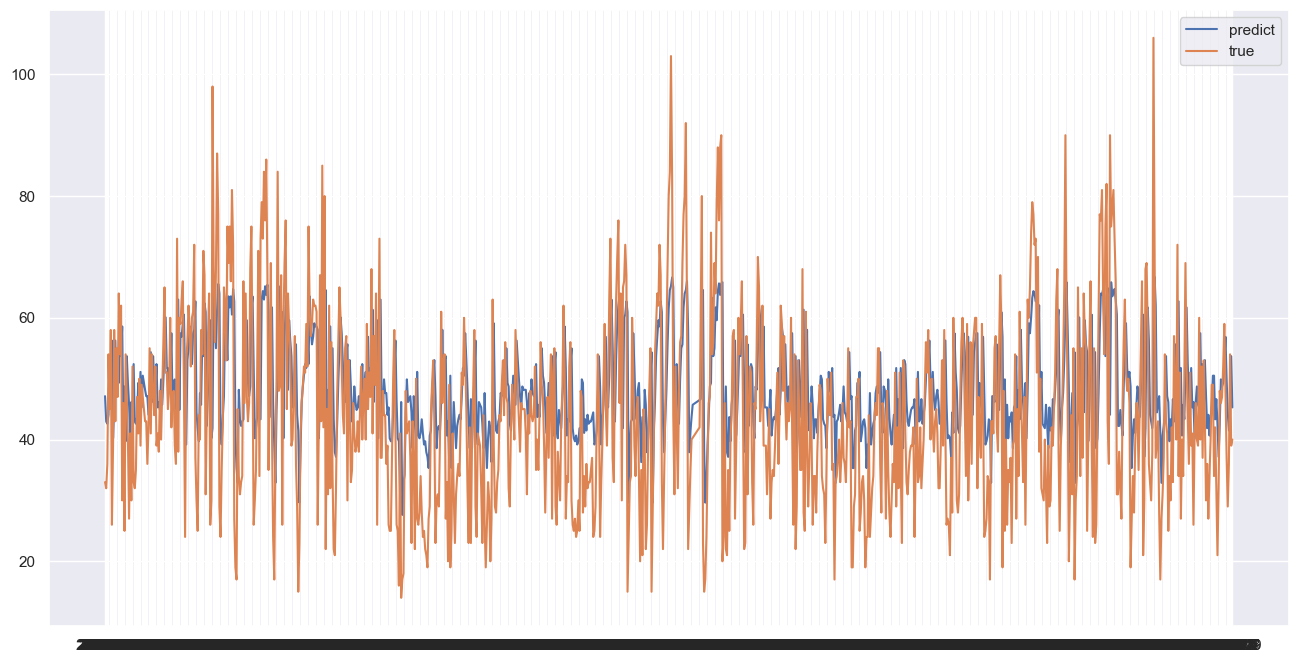

In [ ]:
yhat = model.predict(X_test)
pyplot.plot(yhat, label='predict')
pyplot.plot(y_test, label='true')
pyplot.legend()
pyplot.show()

In [ ]:
MSLE = mean_squared_log_error(y_test, yhat) ** 0.5
print(f'RMSLE: {MSLE:.5f}')

RMSE = mean_squared_error(y_test, yhat) ** 0.5
print(f'RMSE: {RMSE:.5f}')

RMSLE: 0.33772
RMSE: 14.08840
